In [9]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [11]:
from utils import to_radian,res_to_rad,ax_to_w,rep_to_angle
from visualize import plot_cost_func,plot_volume,plot_slices
from cost_functions import cf_ssd
from mask import sphere_mask

In [12]:
from rotation_3d import trilinear_interp,volrotate_trilinear,rotate_coords_3d
from rotation_3d import tricubic_derivatives,tricubic_interp,volrotate_tricubic
from rotation_3d import BSpline_coefficients, Bspline_interp_1d, Bspline_interp, BSpline_derivatives, volrotate_bspline
from Gauss_Newton import Gauss_Newton, axis_derivatives,print_results,sphere_mask,get_nonzero_mask,fourier_filter,get_gradient_P, window,get_mask_weights

In [5]:
oct13_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_10.p','rb'))
oct13_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_8.p','rb'))
oct13_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_6_4.p','rb'))

In [7]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/Oct_13_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = os.listdir(path)
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']


## Load Data

In [7]:
# 8mm_iso_x_rot_0_5_to_2_5_deg_z_trans_rep_0
res = '8'
rad = res_to_rad(res)
rot_ax = 'x'

raw_vol = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
norm_constant = (raw_vol.max()-raw_vol.min())
raw_vol = raw_vol/norm_constant
testVol1 = fourier_filter(raw_vol,rad)

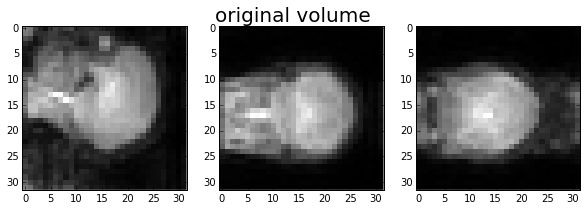

In [14]:
path = '/Users/zyzdiana/Dropbox/THESIS/Dylan_Test_Code/BSplines/'
volume = np.array(np.memmap(path+'filteredImgRotX05to25TransZRep0.dat',dtype=np.float32,mode='c',shape=(32,32,32)))
plot_volume(volume, "original volume")

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


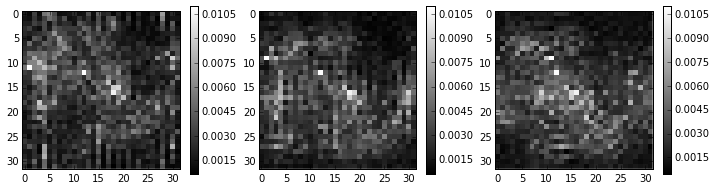

In [9]:
plt.figure(figsize=[12,3])
plt.subplot(1,3,1)
plt.imshow((testVol1-volume).max(axis=0), interpolation='None', cmap='gray')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow((testVol1-volume).max(axis=1), interpolation='None', cmap='gray')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow((testVol1-volume).max(axis=2), interpolation='None', cmap='gray')
plt.colorbar()
plt.show()

In [12]:
FourierPoints = np.array(np.memmap(path+'FourierPoints.dat',
                                   dtype=np.float32,mode='c',shape=(32,32,32,3)))
ImagePoints = np.array(np.memmap(path+'ImagePoints.dat',
                                 dtype=np.float32,mode='c',shape=(32,32,32,3)))
ImagePointWeights = np.array(np.memmap(path+'ImagePointWeights.dat',
                                       dtype=np.float32,mode='c',shape=(32768)))
bSplineCoeffsMat = np.array(np.memmap(path+'bSplineCoeffsMat.dat',
                                      dtype=np.float32,mode='c',shape=(64,64)))

In [13]:
MTensor = np.array(np.memmap(path+'MTensor.dat', dtype=np.float32,mode='c',shape=(32,32,32,6,3)))
ImageDerivs = np.array(np.memmap(path+'ImageDerivs.dat', dtype=np.float32,mode='c',shape=(6,32,32,32)))
WeightedImageDerivs = np.array(np.memmap(path+'WeightedImageDerivs.dat', 
                                         dtype=np.float32,mode='c',shape=(6,32,32,32)))
TargetImgCoeffs = np.array(np.memmap(path+'TargetImgCoeffs.dat', dtype=np.float32,mode='c',shape=(32,32,32,64)))
WeightedMovingImgGradP = np.array(np.memmap(path+'WeightedMovingImgGradP.dat', 
                                            dtype=np.float32,mode='c',shape=(32768,6)))

## Coefficients for generalized interpolation algorithm

In [14]:
# define some scalar
z0 = -2 + np.sqrt(3)
c0 = 6
def computeG(f, N):
    g = np.empty(N)
    g[0] = c0*f[0]
    for i in xrange(1,N-1):
        g[i] = z0*g[i-1] + c0*f[i]
    g[N-1] =  (z0*g[N-2] + c0*f[N-1])/(1 - z0**N)
    return g

def getA(N):
    A = np.eye(N)
    for i in xrange(N-1):
        A[i, N-1] = z0**(i+1)
    return A

def computeH(y_plus, N):
    h = np.zeros(N)
    h[N-1] = -z0*y_plus[N-1]
    for i in xrange(1,N-1):
        h[N-i-1] = -z0*y_plus[N-i-1] + z0*h[N-i]
    h[0] = (-z0*y_plus[0] + z0*h[1])/(1 - z0**N)
    return h

def getB(N):
    B = np.eye(N)
    for i in xrange(1,N):
        B[i, 0] = z0**(N-i)
    return B

def computeY(data, N):
    y_plus = getA(N).dot(computeG(data,N))
    return getB(N).dot(computeH(y_plus,N))

In [15]:
vec = np.array([1,2,3,4,5])
N = len(vec)
g = computeG(vec, N)
print 'g', g
A = getA(N)
y_plus = A.dot(g)
print 'y+', y_plus
h = computeH(y_plus, N)
print 'h', h
B = getB(N)
y = B.dot(h)
print 'y',y

g [  6.          10.39230485  15.21539031  19.92304845  24.62761914]
y+ [ -0.59895066  12.16048835  14.74160697  20.04999832  24.62761914]
h [-0.81818182  2.458763    2.98425991  3.60419736  6.59895066]
y [-0.81818182  2.45454545  3.          3.54545455  6.81818182]


In [16]:
computeY(vec,5)

array([-0.81818182,  2.45454545,  3.        ,  3.54545455,  6.81818182])

In [17]:
def get_coeffs_BSpline(volume):
    shape = volume.shape
    # compute coeff in x-direction
    x_coeff = np.empty(shape)
    for i in xrange(shape[0]):
        for j in xrange(shape[1]):
            x_coeff[i,j,:] = computeY(volume[i,j,:],shape[2])
    # compute coeff in y-direction        
    y_coeff = np.empty(shape)
    for i in xrange(shape[0]):
        for k in xrange(shape[2]):
             y_coeff[i,:,k] = computeY(x_coeff[i,:,k],shape[1])
    # compute coeff in z-direction
    z_coeff = np.empty(shape)
    for j in xrange(shape[1]):
        for k in xrange(shape[2]):
             z_coeff[:,j,k] = computeY(y_coeff[:,j,k],shape[0])
    return z_coeff

In [18]:
img = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], 
                [[2, 2, 3], [5, 5, 6], [8, 8, 9]], 
                [[1, 2, 2], [4, 5, 5], [7, 8, 8]]])

In [19]:
shape = img.shape
x_coeff = np.empty(shape)
for i in xrange(shape[0]):
    for j in xrange(shape[1]):
        x_coeff[i,j,:] = computeY(img[i,j,:],shape[2])
x_coeff

array([[[ -5.44633907e-16,   2.00000000e+00,   4.00000000e+00],
        [  3.00000000e+00,   5.00000000e+00,   7.00000000e+00],
        [  6.00000000e+00,   8.00000000e+00,   1.00000000e+01]],

       [[  1.66666667e+00,   1.66666667e+00,   3.66666667e+00],
        [  4.66666667e+00,   4.66666667e+00,   6.66666667e+00],
        [  7.66666667e+00,   7.66666667e+00,   9.66666667e+00]],

       [[  3.33333333e-01,   2.33333333e+00,   2.33333333e+00],
        [  3.33333333e+00,   5.33333333e+00,   5.33333333e+00],
        [  6.33333333e+00,   8.33333333e+00,   8.33333333e+00]]])

In [20]:
y_coeff = np.empty(shape)
for i in xrange(shape[0]):
    for k in xrange(shape[2]):
         y_coeff[i,:,k] = computeY(x_coeff[i,:,k],shape[1])
y_coeff

array([[[ -3.        ,  -1.        ,   1.        ],
        [  3.        ,   5.        ,   7.        ],
        [  9.        ,  11.        ,  13.        ]],

       [[ -1.33333333,  -1.33333333,   0.66666667],
        [  4.66666667,   4.66666667,   6.66666667],
        [ 10.66666667,  10.66666667,  12.66666667]],

       [[ -2.66666667,  -0.66666667,  -0.66666667],
        [  3.33333333,   5.33333333,   5.33333333],
        [  9.33333333,  11.33333333,  11.33333333]]])

In [21]:
y = np.empty(shape)
for j in xrange(shape[1]):
    for k in xrange(shape[2]):
         y[:,j,k] = computeY(y_coeff[:,j,k],shape[0])
y

array([[[ -3.66666667,  -1.        ,   1.66666667],
        [  2.33333333,   5.        ,   7.66666667],
        [  8.33333333,  11.        ,  13.66666667]],

       [[ -0.33333333,  -1.66666667,   1.        ],
        [  5.66666667,   4.33333333,   7.        ],
        [ 11.66666667,  10.33333333,  13.        ]],

       [[ -3.        ,  -0.33333333,  -1.66666667],
        [  3.        ,   5.66666667,   4.33333333],
        [  9.        ,  11.66666667,  10.33333333]]])

In [22]:
y = get_coeffs_BSpline(img)
print y

[[[ -3.66666667  -1.           1.66666667]
  [  2.33333333   5.           7.66666667]
  [  8.33333333  11.          13.66666667]]

 [[ -0.33333333  -1.66666667   1.        ]
  [  5.66666667   4.33333333   7.        ]
  [ 11.66666667  10.33333333  13.        ]]

 [[ -3.          -0.33333333  -1.66666667]
  [  3.           5.66666667   4.33333333]
  [  9.          11.66666667  10.33333333]]]


In [23]:
x_coeff = np.empty(shape)
for i in xrange(shape[0]):
    for j in xrange(shape[1]):
        x_coeff[i,j,:] = computeY(img[i,j,:],shape[2])
        
tmp = x_coeff-np.roll(x_coeff,1,axis=2)
deriv_X = (tmp + np.roll(tmp,-1,axis=2))/2.0
print deriv_X

[[[ -1.00000000e+00   2.00000000e+00  -1.00000000e+00]
  [ -1.00000000e+00   2.00000000e+00  -1.00000000e+00]
  [ -1.00000000e+00   2.00000000e+00  -1.00000000e+00]]

 [[ -1.00000000e+00   1.00000000e+00   0.00000000e+00]
  [ -1.00000000e+00   1.00000000e+00   4.44089210e-16]
  [ -1.00000000e+00   1.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   1.00000000e+00  -1.00000000e+00]
  [  0.00000000e+00   1.00000000e+00  -1.00000000e+00]
  [  0.00000000e+00   1.00000000e+00  -1.00000000e+00]]]


In [24]:
y_coeff = np.empty(shape)
for i in xrange(shape[0]):
    for k in xrange(shape[2]):
         y_coeff[i,:,k] = computeY(img[i,:,k],shape[1])

tmp = y_coeff-np.roll(y_coeff,1,axis=1)
deriv_Y = (tmp + np.roll(tmp,-1,axis=1))/2.0
print deriv_Y

[[[-3. -3. -3.]
  [ 6.  6.  6.]
  [-3. -3. -3.]]

 [[-3. -3. -3.]
  [ 6.  6.  6.]
  [-3. -3. -3.]]

 [[-3. -3. -3.]
  [ 6.  6.  6.]
  [-3. -3. -3.]]]


In [25]:
z_coeff = np.empty(shape)
for j in xrange(shape[1]):
    for k in xrange(shape[2]):
         z_coeff[:,j,k] = computeY(img[:,j,k],shape[0])

tmp = z_coeff-np.roll(z_coeff,1,axis=0)
deriv_Z = (tmp + np.roll(tmp,-1,axis=0))/2.0
print deriv_Z

[[[  1.00000000e+00  -4.44089210e-16   1.00000000e+00]
  [  1.00000000e+00   0.00000000e+00   1.00000000e+00]
  [  1.00000000e+00  -1.77635684e-15   1.00000000e+00]]

 [[ -2.22044605e-16   2.22044605e-16  -1.00000000e+00]
  [ -2.22044605e-16   0.00000000e+00  -1.00000000e+00]
  [  0.00000000e+00   8.88178420e-16  -1.00000000e+00]]

 [[ -1.00000000e+00   2.22044605e-16   4.44089210e-16]
  [ -1.00000000e+00   0.00000000e+00   4.44089210e-16]
  [ -1.00000000e+00   8.88178420e-16   8.88178420e-16]]]


In [26]:
res = np.array([deriv_X,deriv_Y,deriv_Z])
res.shape

(3, 3, 3, 3)

In [27]:
bSplineCoeffsMat

array([[ 0.00462963,  0.01851852,  0.00462963, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01388889,  0.        ,  0.01388889, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01388889, -0.02777778,  0.01388889, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [-0.01388889,  0.        ,  0.01388889, ...,  0.        ,
         0.01388889,  0.        ],
       [ 0.01388889, -0.02777778,  0.01388889, ..., -0.02777778,
         0.01388889,  0.        ],
       [-0.00462963,  0.01388889, -0.01388889, ...,  0.01388889,
        -0.01388889,  0.00462963]], dtype=float32)

In [28]:
%%time
N = 3
tmp = np.empty([N,N,N,64])
idx = 0
for i in xrange(-1,3):
    for j in xrange(-1, 3):
        for k in xrange(-1, 3):
            tmp[:,:,:,idx] = np.roll(np.roll(np.roll(y, N-i, axis=0), N-j, axis=1), N-k, axis=2)
            idx += 1
coeffs = np.empty([N,N,N,64])
for i in xrange(N):
    for j in xrange(N):
        for k in xrange(N):
            coeffs[i,j,k,:] = bSplineCoeffsMat.dot(tmp[i,j,k,:])

CPU times: user 2.36 ms, sys: 953 µs, total: 3.31 ms
Wall time: 2.57 ms


In [29]:
simpleImgCoeffs = np.array(np.memmap('/Users/zyzdiana/Downloads/Bsplines/simpleImgCoeffs.dat', 
                                     dtype=np.float32,mode='c',shape=(3,3,3,64)))
np.allclose(simpleImgCoeffs,coeffs)

True

In [31]:
coeffs1 = BSpline_derivatives(img)
np.allclose(coeffs1,res)

False

In [32]:
coeffs2 = BSpline_coefficients(img)
np.allclose(coeffs2,coeffs)

True

In [ ]:
#RotateRight[image, {0, 0, -1}]
print np.roll(img,-1,axis=2)
#RotateRight[image, {0, 0, 1}]
print np.roll(img, 1, axis=2)

In [ ]:
#RotateRight[image, {0, -1, 0}]
print np.roll(img, -1, axis=1)
#RotateRight[image, {0, 1, 0}]
print np.roll(img, 1, axis=1)

In [ ]:
#RotateRight[image, {-1, 0, 0}]
print np.roll(img, -1, axis=0)
#RotateRight[image, {1, 0, 0}]
print np.roll(img, 1, axis=0)

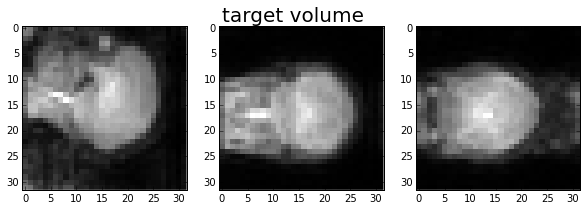

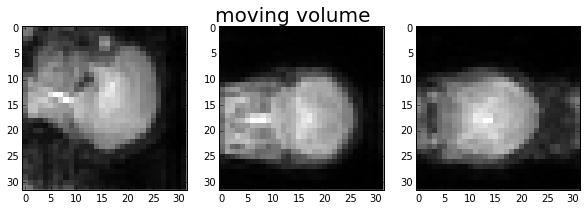

In [19]:
path = '/Users/zyzdiana/Dropbox/THESIS/Dylan_Test_Code/BSplines/'
volume_target = np.array(np.memmap(path+'filteredImgRotX05to25TransZRep0.dat',dtype=np.float32,mode='c',shape=(32,32,32)))
plot_volume(volume_target, "target volume")
volume_moving = np.array(np.memmap(path+'movingImg.dat',dtype=np.float32,mode='c',shape=(32,32,32)))
plot_volume(volume_moving, "moving volume")

In [34]:
%%time
coeffs = BSpline_coefficients(volume_target)

CPU times: user 661 ms, sys: 22.8 ms, total: 683 ms
Wall time: 682 ms


In [35]:
# Rotation of 0 returns itself
N = 32
for i in xrange(N):
    for j in xrange(N):
        for k in xrange(N):
            if not np.allclose(volume_target[i,j,k],Bspline_interp_1d(volume_target.shape, coeffs, j, i, k)):
                print i, j, k

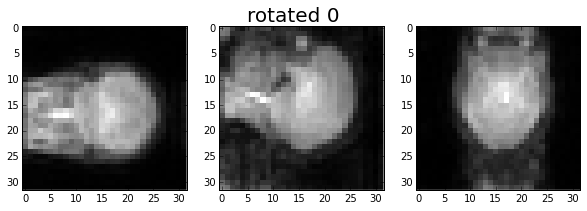

CPU times: user 2.8 s, sys: 31.5 ms, total: 2.83 s
Wall time: 2.85 s


In [36]:
%%time
vol_rotated = np.empty(volume_target.shape)
N = 32
for i in xrange(N):
    for j in xrange(N):
        for k in xrange(N):
            vol_rotated[i,j,k] = Bspline_interp_1d(volume_target.shape, coeffs, i, j, k)
plot_volume(vol_rotated, "rotated 0")

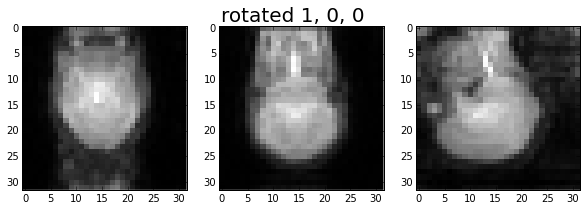

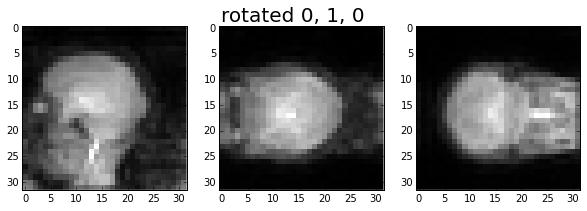

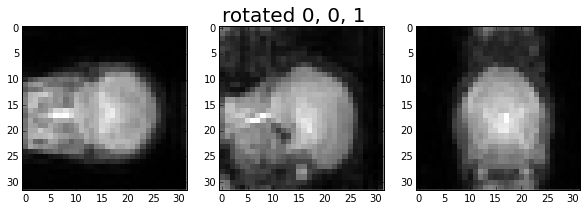

In [37]:
derivs = tricubic_derivatives(volume_target)
vol_cubic = volrotate_tricubic(volume_target.shape,derivs,90,1,0,0)
plot_volume(vol_cubic, "rotated 1, 0, 0")

vol_cubic = volrotate_tricubic(volume_target.shape,derivs,90,0,1,0)
plot_volume(vol_cubic, "rotated 0, 1, 0")

vol_cubic = volrotate_tricubic(volume_target.shape,derivs,90,0,0,1)
plot_volume(vol_cubic, "rotated 0, 0, 1")

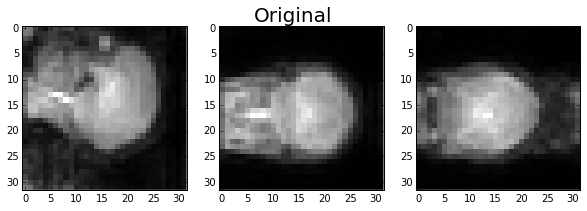

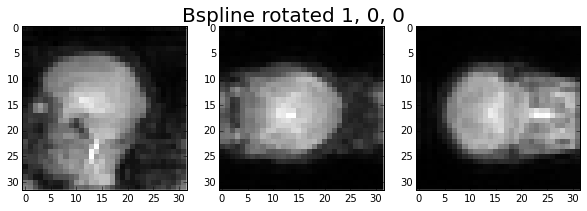

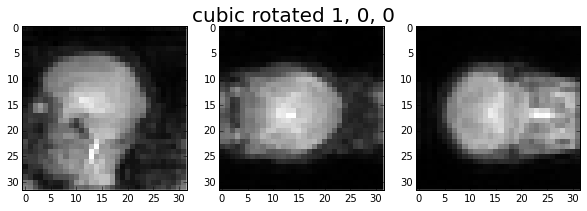

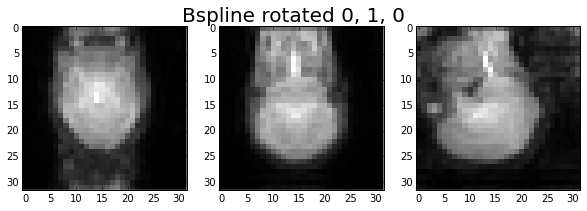

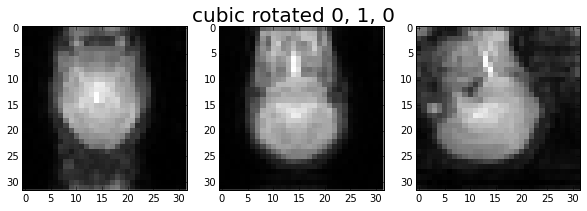

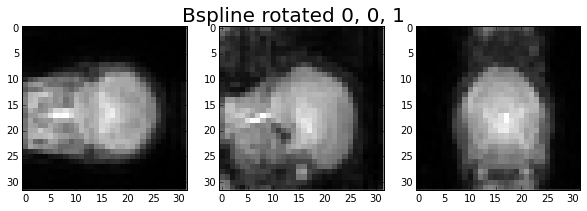

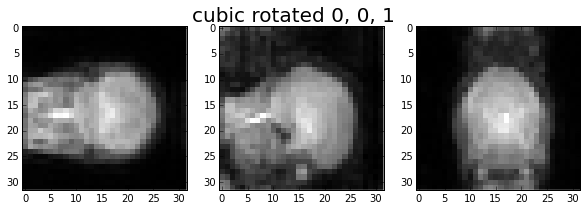

In [38]:
plot_volume(volume_target, "Original")

vol_rotated = volrotate_bspline(volume_target.shape, coeffs, -90, 1, 0, 0)
plot_volume(vol_rotated, "Bspline rotated 1, 0, 0")

vol_cubic = volrotate_tricubic(volume_target.shape,derivs,90,0,1,0)
plot_volume(vol_cubic, "cubic rotated 1, 0, 0")

vol_rotated = volrotate_bspline(volume_target.shape, coeffs, -90, 0, 1, 0)
plot_volume(vol_rotated, "Bspline rotated 0, 1, 0")

vol_cubic = volrotate_tricubic(volume_target.shape,derivs,90,1,0,0)
plot_volume(vol_cubic, "cubic rotated 0, 1, 0")

vol_rotated = volrotate_bspline(volume_target.shape, coeffs, -90, 0, 0, 1)
plot_volume(vol_rotated, "Bspline rotated 0, 0, 1")

vol_cubic = volrotate_tricubic(volume_target.shape,derivs,90,0,0,1)
plot_volume(vol_cubic, "cubic rotated 0, 0, 1")

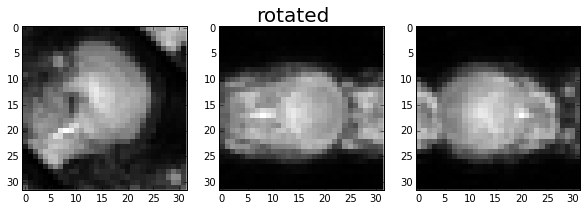

CPU times: user 649 ms, sys: 12.1 ms, total: 661 ms
Wall time: 666 ms


In [39]:
%%time
vol_rotated = volrotate_bspline(volume_target.shape, coeffs, -45, 1, 0, 0)
plot_volume(vol_rotated, "rotated")

# Gauss Newton
## B-Spline

In [40]:
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not ((TargetImgCoeffs[i,j,k]-coeffs[i,j,k]) < 1e-5).all():
                print i, j, k

In [41]:
axis_derivs = BSpline_derivatives(volume_moving)
imgDerivs = get_gradient_P(volume_moving,BSpline_derivatives,mask=False)

In [ ]:
derivs = np.empty([32768,6])
idx = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            #derivs[idx,:] = ImagePointWeights[idx]*MTensor[i,j,k].dot(axis_derivs[i,j,k])
            derivs[idx,:] = MTensor[i,j,k].dot(axis_derivs[i,j,k])

In [8]:
%%time
s0,s1,s2 = volume_target.shape

testVol1_masked = sphere_mask(volume_target,rad)

vol1_dervs = get_gradient_P(volume_target, axis_derivatives=BSpline_derivatives)
vol1_dervs_masked = get_gradient_P(testVol1_masked, axis_derivatives=BSpline_derivatives)

vol2_coeffs = BSpline_coefficients(volume_moving)

NameError: name 'volume_target' is not defined

In [95]:
vol2_dervs = get_gradient_P(volume_moving, axis_derivatives=BSpline_derivatives)

Converged in 17 iterations!


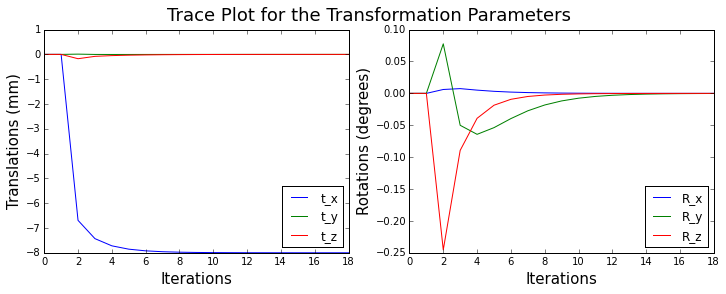

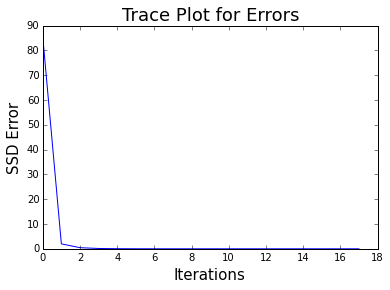

min error:  9.88131408582e-08
parameters at min error:  [ -9.99983286e-01  -6.04783620e-07  -8.65393711e-06   9.94992200e-08
  -2.84922702e-06  -2.45048972e-07]
translation (in mm): [ -7.99986629e+00  -4.83826896e-06  -6.92314969e-05]
rotations (in degrees): [  5.70088537e-06  -1.63248683e-04  -1.40402718e-05]


In [96]:
# GN without mask derivs on the same volume
from Gauss_Newton import Gauss_Newton2
res = '8'
errors, Ps = Gauss_Newton2(volume_target, vol2_dervs, volume_moving, vol2_coeffs, mask=False, 
                          divide_factor = 1., alpha = 1., max_iter = 20, decrease_factor = 0.25,
                          interp = Bspline_interp)
print_results(errors, Ps, float('.'.join(res.split('_'))))

Converged in 7 iterations!


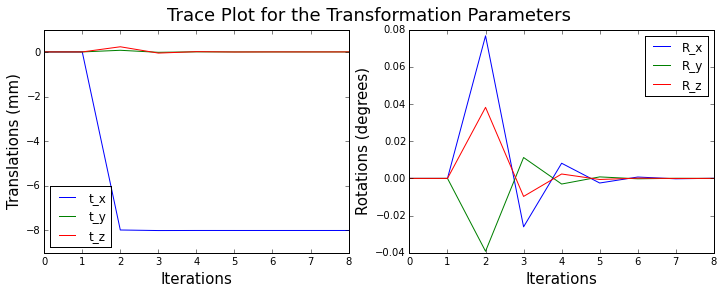

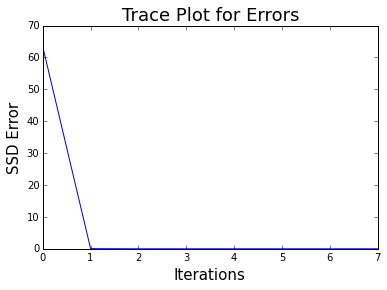

min error:  5.01893789167e-09
parameters at min error:  [ -9.99999853e-01   2.51168118e-06   5.86312670e-06   1.07488879e-06
  -2.72059479e-07   1.43941946e-07]
translation (in mm): [ -7.99999882e+00   2.00934494e-05   4.69050136e-05]
rotations (in degrees): [  6.15865913e-05  -1.55878599e-05   8.24726598e-06]


In [148]:
# GN with mask derivs on the same volume
errors, Ps = Gauss_Newton2(testVol1_masked, vol1_dervs_masked, volume_moving, vol2_coeffs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 20, decrease_factor = 0.25,
                          interp = Bspline_interp)
print_results(errors, Ps, float('.'.join(res.split('_'))))

Converged in 11 iterations!


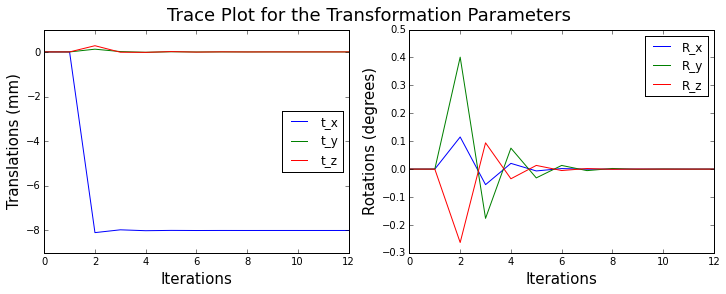

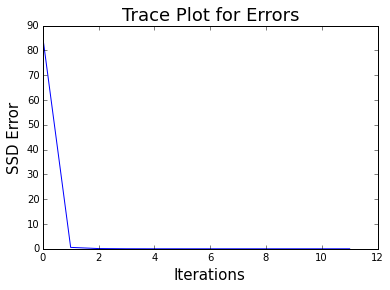

min error:  1.68297933757e-08
parameters at min error:  [ -1.00000095e+00  -1.86866056e-06  -6.82207705e-06  -2.63460506e-07
   1.14571945e-06  -3.85892685e-07]
translation (in mm): [ -8.00000760e+00  -1.49492845e-05  -5.45766164e-05]
rotations (in degrees): [ -1.50951751e-05   6.56448892e-05  -2.21100222e-05]


In [90]:
# GN without mask
res = '8'
errors, Ps = Gauss_Newton(volume_target, vol1_dervs, volume_moving, vol2_coeffs, mask=False, 
                          divide_factor = 1., alpha = 1., max_iter = 20, decrease_factor = 0.25,
                          interp = Bspline_interp)
print_results(errors, Ps, float('.'.join(res.split('_'))))

Converged in 7 iterations!


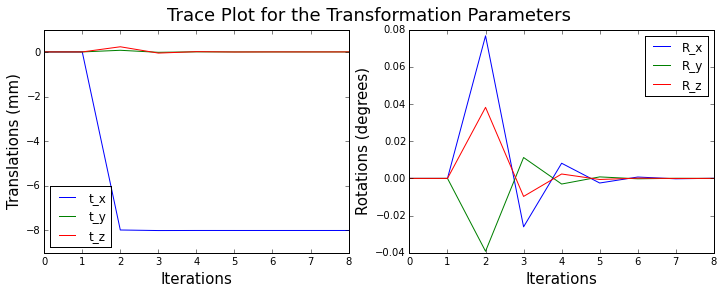

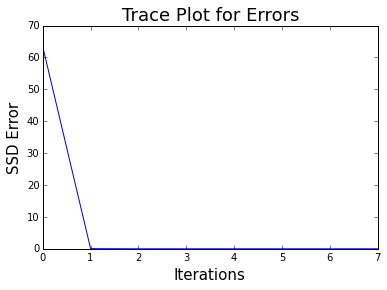

min error:  5.01893789167e-09
parameters at min error:  [ -9.99999853e-01   2.51168118e-06   5.86312670e-06   1.07488879e-06
  -2.72059479e-07   1.43941946e-07]
translation (in mm): [ -7.99999882e+00   2.00934494e-05   4.69050136e-05]
rotations (in degrees): [  6.15865913e-05  -1.55878599e-05   8.24726598e-06]


In [149]:
# GN with mask
errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, volume_moving, vol2_coeffs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 20, decrease_factor = 0.25,
                          interp = Bspline_interp)
print_results(errors, Ps, float('.'.join(res.split('_'))))

## Tricubic

In [21]:
%%time
res = '8'
rad = res_to_rad(res)
s0,s1,s2 = volume_target.shape

testVol1_masked = sphere_mask(volume_target,rad)
vol1_dervs_masked = get_gradient_P(testVol1_masked, mask=False)

vol1_dervs = get_gradient_P(volume_target, mask=False)

vol2_dervs = tricubic_derivatives(volume_moving)

CPU times: user 53.9 s, sys: 586 ms, total: 54.5 s
Wall time: 55.4 s


Converged in 6 iterations!


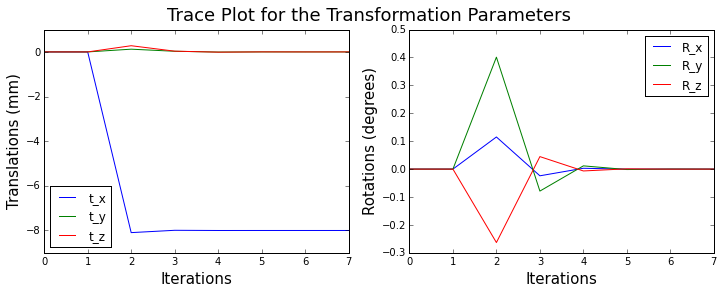

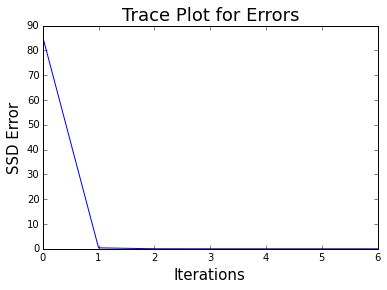

min error:  3.51277460226e-09
parameters at min error:  [ -9.99999898e-01   2.69245953e-06   4.38448691e-06   2.04467241e-08
  -5.13134975e-07   3.43041051e-07]
translation (in mm): [ -7.99999919e+00   2.15396763e-05   3.50758953e-05]
rotations (in degrees): [  1.17151100e-06  -2.94004684e-05   1.96548044e-05]


In [74]:
# GN without mask
errors, Ps = Gauss_Newton(volume_target, vol1_dervs, volume_moving, vol2_dervs, mask=False, 
                          divide_factor = 1., alpha = 1., max_iter = 15, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

Converged in 4 iterations!


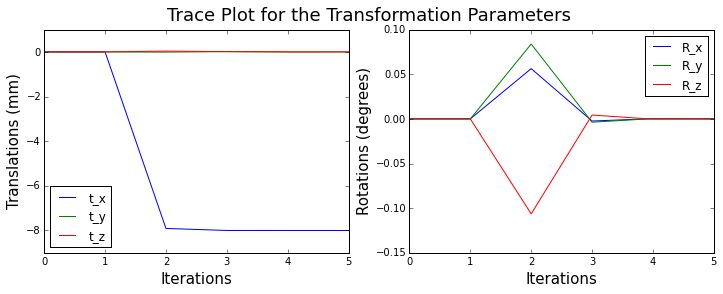

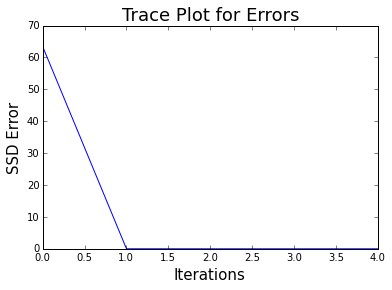

min error:  3.28659608035e-09
parameters at min error:  [ -9.99999793e-01   4.75758943e-06   6.53583897e-06  -6.05444528e-08
  -2.81806963e-07   3.53933048e-07]
translation (in mm): [ -7.99999834e+00   3.80607155e-05   5.22867118e-05]
rotations (in degrees): [ -3.46894162e-06  -1.61463496e-05   2.02788699e-05]


In [75]:
# GN with mask
errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs_masked, volume_moving, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 15, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

# New Error Metric

The RMS error is defined as 
$$E^2_{RMS} = \frac{1}{5} R^2 \text{Trace}(A^TA)+t^Tt$$

In [143]:
from rotation_3d import rotation_matrix_zyx

def RMS(params, true_params, rad, res):
    p = true_params-params
    A = rotation_matrix_zyx(p[3], p[4], p[5], True)
    t = p[:3]*res
    return 0.2*rad**2*np.trace((A.T).dot(A))+ (t.T).dot(t)

In [144]:
RMS(Ps[-1],np.array([-1,0,0,0,0,0]),16,8)

153.60000000339673